In [1]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle 

npr.seed(0)

In [2]:
from general_utilities import * #imports utilities.py file which has functions for plotting psychometrics and other useful things
from HMM_functions import * #imports HMM_functions.py file which has functions for getting the data read for the ssm.HMM
from functions_for_making_plots import * 
from decoder_functions import * #imports decoder_functions.py file which has functions for decoding things from neural data 
from data_extraction_for_svm import *

In [3]:
colors = np.array([[0,102,51],[237,177,32],[233,0,111],[39,110,167]])/255

#Remove right and top spines from plots (personal preference)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
dpi = 1600

save_path = '/Users/akhilbandi/Documents/Portfolio/code_projects/Bandi_Runyan 2024/figures/'

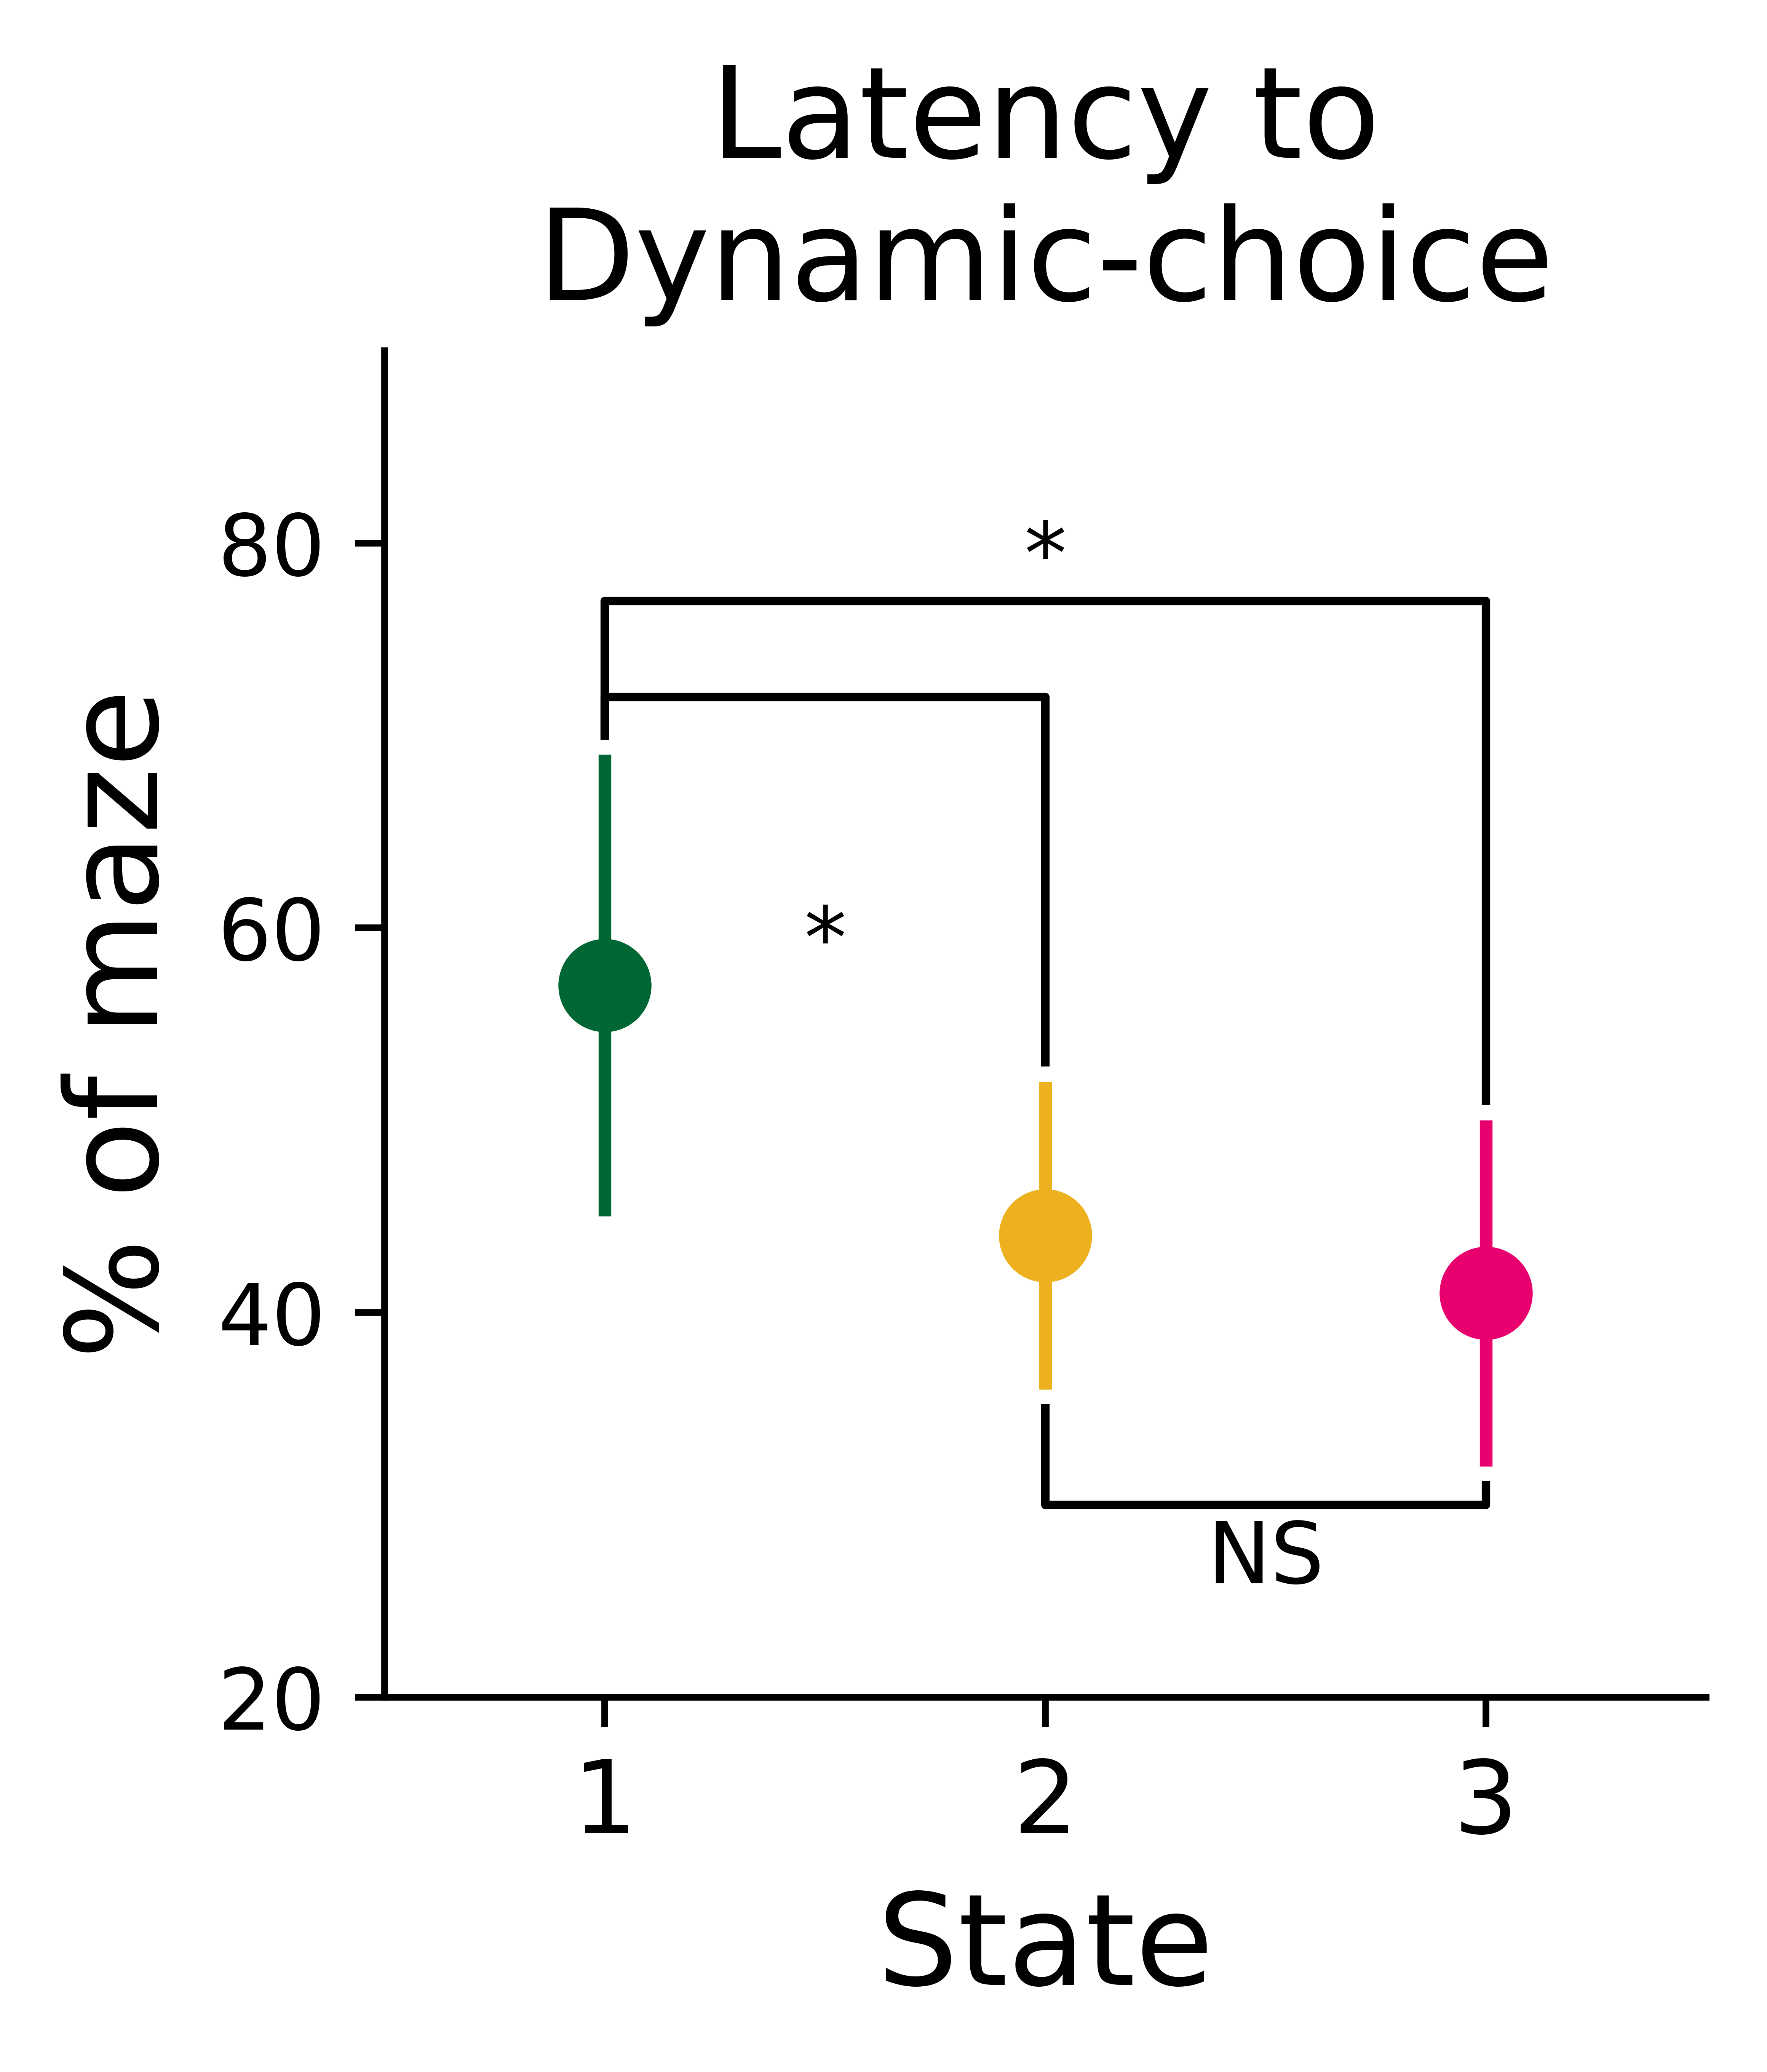

In [6]:
fig, axs = plt.subplots(1,figsize = (3,3.5), facecolor='w', edgecolor='k', dpi=1600)

dynamic_choice = [.57, .44, .41]
errors = [0.12, 0.08, 0.09]

# Your existing plotting code
for z, (frac, error) in enumerate(zip(dynamic_choice, errors)):
    axs.scatter(z, frac*100, color=colors[z], s=100)  # scatter plot
    axs.errorbar(z, frac*100, yerr=error*100, color=colors[z], linestyle='none')  # error bars

num_states = 3
if num_states == 3:
    axs.set_xticks([0, 1, 2])
    axs.set_xticklabels(['1', '2', '3'], fontsize=12)

# Your existing axis setup code
axs.set_yticks([20, 40, 60, 80])
axs.set_yticklabels(['20', '40', '60', '80'])
axs.set_xlabel('State', size=15)
axs.set_ylabel('% of maze', size=15)
axs.set_xlim([-0.5, 2.5])
axs.set_ylim([20, 90])

axs.set_title('Latency to\nDynamic-choice', size=15)

# Adding comparison lines and asterisks for significance
max_dynamic_choice = max(dynamic_choice)
y, h, col = max_dynamic_choice * 100 + 10, 5, 'k'

# Compare 1 to 2
axs.plot([0, 0, 1, 1], [y+3, y+h, y+h, y-14], lw=1, c=col)
axs.text((0 + 1) / 2, y - 10, "*", ha='center', va='bottom', color=col)

# Compare 1 to 3
axs.plot([0, 0, 2, 2], [y + 3, y + 2*h, y + 2*h, y-16], lw=1, c=col)
axs.text((0 + 2) / 2, y + 2*h, "*", ha='center', va='bottom', color=col)

# Compare 1 to 3
axs.plot([1, 1, 2, 2], [35,30,30,31], lw=1, c=col)
axs.text((1 + 2) / 2, 25, "NS", ha='center', va='bottom', color=col)

# Show the plot
fig.tight_layout()

plt.savefig(save_path + 'choice_formation.svg', format='svg', bbox_inches="tight")

In [183]:
from collections import Counter
from itertools import accumulate

def get_data_from_each_CV_fold(train_directory, test_directory, fold):
    '''
        function to locate and arrange the train and test datasets prior to training the GLM encoding model 
        
        inputs:
        train_directory: location of the training datasets 
        test_directory: location of the testing datasets 
        fold: cross validation fold for the specified dataset 
        
        outputs:
        X_train, Y_train: Variables + neural data for training set 
        X_test, Y_test: Variables + neural data for testing set 
        count_of_values: # and position of unique variables for fitting 
        IDS_for_count_of_values: names of the unique variables for fitting - helps for B-weight analysis 
    '''
    directory_train = train_directory.format(fold)
    os.chdir(directory_train)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    #response_matrix[response_matrix > 0.05] = 1 #binarizes response 

    X_train = behav_matrix
    Y_train = response_matrix
    
    behav_IDS = []
    for trial in list(range(behav_ids['behav_big_matrix_ids'][0].shape[0])):
        behav_IDS.append(behav_ids['behav_big_matrix_ids'][0][trial][0])

    # Count the occurrences of each element in the list
    counter = Counter(behav_IDS)

    # Get the unique values
    unique_values = list(counter.keys())

    # Get the count of each unique value
    count_of_values = list(counter.values())

    IDS_index = np.array(list(accumulate(count_of_values)))-1
    IDS_for_count_of_values = []
    for index in IDS_index:
        IDS_for_count_of_values.append(behav_IDS[index])
        
    directory_test = test_directory.format(fold)
    os.chdir(directory_test)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    #response_matrix[response_matrix > 0.05] = 1

    X_test = behav_matrix
    Y_test = response_matrix
    
    # Clean up design matrix and z-score along sample dimension
    X_train = X_train.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_train = 10 * Y_train.T

    X_test = X_test.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_test = 10 * Y_test.T
    
    return X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values

data_directory = "/Volumes/Runyan2/Akhil/Runyan-Piasini-2017-master/Data/PPC B67 0629/state1_model" 
#save_directory = "/Volumes/Runyan5/Connie/ProcessedData/HA11-1R/2023-05-05/VR/results_GPU"

frac_dev_expl_all = []
for fold_number in list(range(0,1)): #can change this to fit however many folds you need 
    train_directory = data_directory + "/prepost trial cv 73 #{}".format(fold_number+1)
    test_directory = data_directory + "/prepost trial cv 73 #{}/test".format(fold_number+1)

    
    [X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values] = get_data_from_each_CV_fold(train_directory,
                                                                                                                test_directory,
                                                                                                                fold_number+1)
        
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

def perform_pca(spiking_matrix, num_pcs=5):
    # Perform PCA on the spiking matrix
    pca = PCA(n_components=num_pcs)
    pcs = pca.fit_transform(spiking_matrix)

    # Maximum-normalize and z-score the PCs
    pcs = (pcs - np.min(pcs, axis=0)) / (np.max(pcs, axis=0) - np.min(pcs, axis=0))
    pcs = (pcs - np.mean(pcs, axis=0)) / np.std(pcs, axis=0)
    
    return pcs

def convolve_with_boxcars(pcs, boxcar_width=2):
    num_frames, num_pcs = pcs.shape
    
    # Create the boxcar functions
    boxcar1 = np.zeros(num_frames)
    boxcar1[:boxcar_width] = 1
    
    boxcar2 = np.zeros(num_frames)
    boxcar2[boxcar_width:2*boxcar_width] = 1
    
    # Convolve each PC with the boxcar functions
    convolved_pcs = np.zeros((num_frames, num_pcs * 2))
    for i in range(num_pcs):
        convolved_pcs[:, i*2] = np.convolve(pcs[:, i], boxcar1, mode='same')
        convolved_pcs[:, i*2+1] = np.convolve(pcs[:, i], boxcar2, mode='same')
    
    return convolved_pcs

def convolve_with_gaussians(pcs, std_dev=2, spacing=4):
    num_frames, num_pcs = pcs.shape
    
    # Create the Gaussian basis functions
    gaussian1 = gaussian_filter1d(np.eye(num_frames), std_dev, mode='constant')
    gaussian2 = np.roll(gaussian1, spacing, axis=0)
    
    # Convolve each PC with the Gaussian basis functions
    convolved_pcs = np.zeros((num_frames, num_pcs * 2))
    for i in range(num_pcs):
        convolved_pcs[:, i*2] = np.convolve(pcs[:, i], gaussian1[:, i], mode='same')
        convolved_pcs[:, i*2+1] = np.convolve(pcs[:, i], gaussian2[:, i], mode='same')
    
    return convolved_pcs

def compute_functional_coupling_predictors(spiking_matrix, frames_per_bin=15, num_pcs=5, basis_function_width=15):
    # Perform PCA on the spiking matrix
    num_bins = spiking_matrix.shape[0] // frames_per_bin
    num_frames = num_bins * frames_per_bin
    binned_matrix = np.reshape(spiking_matrix[:num_frames], 
                               (num_bins, frames_per_bin, spiking_matrix.shape[1]))
    binned_matrix = np.mean(binned_matrix, axis=1)
    
    pca = PCA(n_components=num_pcs)
    pcs = pca.fit_transform(binned_matrix)
    
    # Maximum-normalize and z-score the PCs
    pcs = (pcs - np.min(pcs, axis=0)) / (np.max(pcs, axis=0) - np.min(pcs, axis=0))
    pcs = (pcs - np.mean(pcs, axis=0)) / np.std(pcs, axis=0)
    
    # Convolve the PCs with Gaussian basis functions
    basis_functions = np.arange(-basis_function_width, basis_function_width + 1, basis_function_width)
    predictors = np.zeros((num_pcs * len(basis_functions), num_frames))
    for i in range(num_pcs):
        pc_expanded = np.repeat(pcs[:, i], frames_per_bin)
        for j, bf in enumerate(basis_functions):
            sigma = np.abs(bf)
            if sigma > 0:
                predictors[i * len(basis_functions) + j, :num_frames] = gaussian_filter1d(pc_expanded, sigma=sigma)
            else:
                predictors[i * len(basis_functions) + j, :num_frames] = pc_expanded
    
    return predictors

spiking_matrix = Y_train  # Your neural data matrix 
pcs = perform_pca(spiking_matrix, 5)
convolved_pcs = convolve_with_gaussians(pcs, std_dev=2, spacing=15)
coupling_predictors = compute_functional_coupling_predictors(spiking_matrix, frames_per_bin=30, num_pcs=5, basis_function_width=4)

coupling_predictors.shape

(15, 21600)

In [184]:
convolved_pcs.shape

(21615, 10)

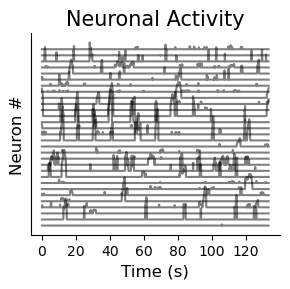

In [190]:
fig,axs = plt.subplots(1, figsize = (3,3), dpi=100)

start, stop = 0,2000
spiking_matrix2 = spiking_matrix
for neuron_num in list(range(30)): #num_cells
    axs.plot(spiking_matrix2[start:stop, neuron_num]/2 + neuron_num, color='black', alpha=0.5)
axs.set_title('Neuronal Activity', fontsize=15)
axs.set_ylabel('Neuron #', fontsize=12)
axs.set_xticks([0,300,600,900,1200,1500,1800])
axs.set_xticklabels(['0','20','40','60','80','100','120'])
axs.set_xlabel('Time (s)', fontsize=12)
axs.set_yticks([])

fig.tight_layout()

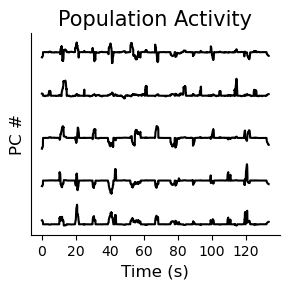

In [191]:
fig,axs = plt.subplots(1, figsize = (3,3), dpi=100)

start, stop = 0,2000

for PC in [0, 1, 2, 3, 4]: #num_cells
    axs.plot(pcs[start:stop, PC]/20 + PC, color='black')
    
axs.set_title('Population Activity', fontsize=15)
axs.set_ylabel('PC #', fontsize=12)
axs.set_xticks([0,300,600,900,1200,1500,1800])
axs.set_xticklabels(['0','20','40','60','80','100','120'])
axs.set_xlabel('Time (s)', fontsize=12)
axs.set_yticks([])

fig.tight_layout()

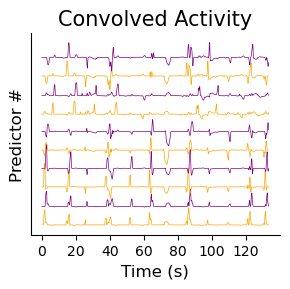

In [192]:
fig,axs = plt.subplots(1, figsize = (3,3), dpi=100)

start, stop = 0,2000

for PC in [0, 2, 4, 6, 8]: #num_cells
    axs.plot(convolved_pcs[start:stop, PC]/5 + PC-1, color='orange', lw=0.5)
    axs.plot(convolved_pcs[start:stop, PC+1]/5 + PC, color='purple', lw=0.5)
    

axs.set_title('Convolved Activity', fontsize=15)
axs.set_ylabel('Predictor #', fontsize=12)
axs.set_xticks([0,300,600,900,1200,1500,1800])
axs.set_xticklabels(['0','20','40','60','80','100','120'])
axs.set_xlabel('Time (s)', fontsize=12)
axs.set_yticks([])

fig.tight_layout()

In [229]:
fig, axs = plt.subplots(1, 3, figsize = (8,3.5), dpi=1600, sharey=False)

#predictor_list = [0,2,4]
title_list = ['Sound\nPredictors', 'Position/Choice\nPredictors', 'Running velocity\nPredictors']

x = 0 
axs[0].errorbar(x=[1,2], y=[32, 36], yerr=[12, 9], fmt='o', color='red')
axs[0].plot([1,2], [32, 36], color='red')

axs[0].errorbar(x=[1.1,2.1], y=[18,30], yerr=[3, 8], fmt='o', color='blue')
axs[0].plot([1.1,2.1], [18,30], color='blue')

axs[0].set_xticks(list(range(1,3)))
axs[0].set_xticklabels([], rotation=45, fontsize=15)
#axs[0].set_xticklabels(['State 1', 'All State'], rotation=45, fontsize=15)
axs[0].set_ylabel('total abs(β weight)', fontsize=15)
axs[0].set_title(title_list[x], fontsize=15)
axs[0].set_xlim([0.5,2.5])
axs[0].set_ylim([0,50])

axs[0].plot([1, 1, 2, 2], [45,49,49,36+10], lw=1, c='black')
axs[0].text((1 + 2) / 2, 44, "NS", ha='center', va='bottom', color='black')

axs[0].plot([1.1, 1.1, 2.1, 2.1], [18-4,9,9,30-9], lw=1, c='black')
axs[0].text((1.1 + 2.1) / 2, 10, "**", ha='center', va='bottom', color='black')

axs[0].set_xticklabels(['State 1', 'All State'], rotation=45, fontsize=15)

axs[1].errorbar(x=[1,2], y=[18, 17], yerr=[1.5, 2], fmt='o', color='red')
axs[1].plot([1,2], [18, 17], color='red')

axs[1].errorbar(x=[1.1,2.1], y=[12,19], yerr=[0/5, 3], fmt='o', color='blue')
axs[1].plot([1.1,2.1], [12,19], color='blue')

axs[1].set_xticks(list(range(1,3)))
axs[1].set_xticklabels([], rotation=45, fontsize=15)
#axs[0].set_xticklabels(['State 1', 'All State'], rotation=45, fontsize=15)
axs[1].set_ylabel('total abs(β weight)', fontsize=15)
axs[1].set_title(title_list[x+1], fontsize=15)
axs[1].set_xlim([0.5,2.5])
axs[1].set_ylim([0,50])

axs[1].plot([1, 1, 2, 2], [20,22,22,20], lw=1, c='black')
axs[1].text((1 + 2) / 2, 22, "NS", ha='center', va='bottom', color='black')

axs[1].plot([1.1, 1.1, 2.1, 2.1], [10,9,9,15], lw=1, c='black')
axs[1].text((1.1 + 2.1) / 2, 9, "*", ha='center', va='bottom', color='black')

axs[1].set_xticklabels(['State 1', 'All State'], rotation=45, fontsize=15)

axs[2].errorbar(x=[1,2], y=[12, 8], yerr=[3, 0.8], fmt='o', color='red')
axs[2].plot([1,2], [12, 8], color='red')

axs[2].errorbar(x=[1.1,2.1], y=[9,13], yerr=[1, 3], fmt='o', color='blue')
axs[2].plot([1.1,2.1], [9,13], color='blue')

axs[2].set_xticks(list(range(1,3)))
axs[2].set_xticklabels([], rotation=45, fontsize=15)
#axs[0].set_xticklabels(['State 1', 'All State'], rotation=45, fontsize=15)
axs[2].set_ylabel('total abs(β weight)', fontsize=15)
axs[2].set_title(title_list[x+2], fontsize=15)
axs[2].set_xlim([0.5,2.5])
axs[2].set_ylim([0,50])

axs[2].plot([1, 1, 2, 2], [16,17,17,10], lw=1, c='black')
axs[2].text((1 + 2) / 2, 17, "*", ha='center', va='bottom', color='black')

axs[2].plot([1.1, 1.1, 2.1, 2.1], [7,4,4,9], lw=1, c='black')
axs[2].text((1.1 + 2.1) / 2, 4, "*", ha='center', va='bottom', color='black')

axs[2].set_xticklabels(['State 1', 'All State'], rotation=45, fontsize=15)

fig.tight_layout()

plt.savefig(save_path + 'B_weights_coupling_GLM.svg', format='svg', bbox_inches="tight")

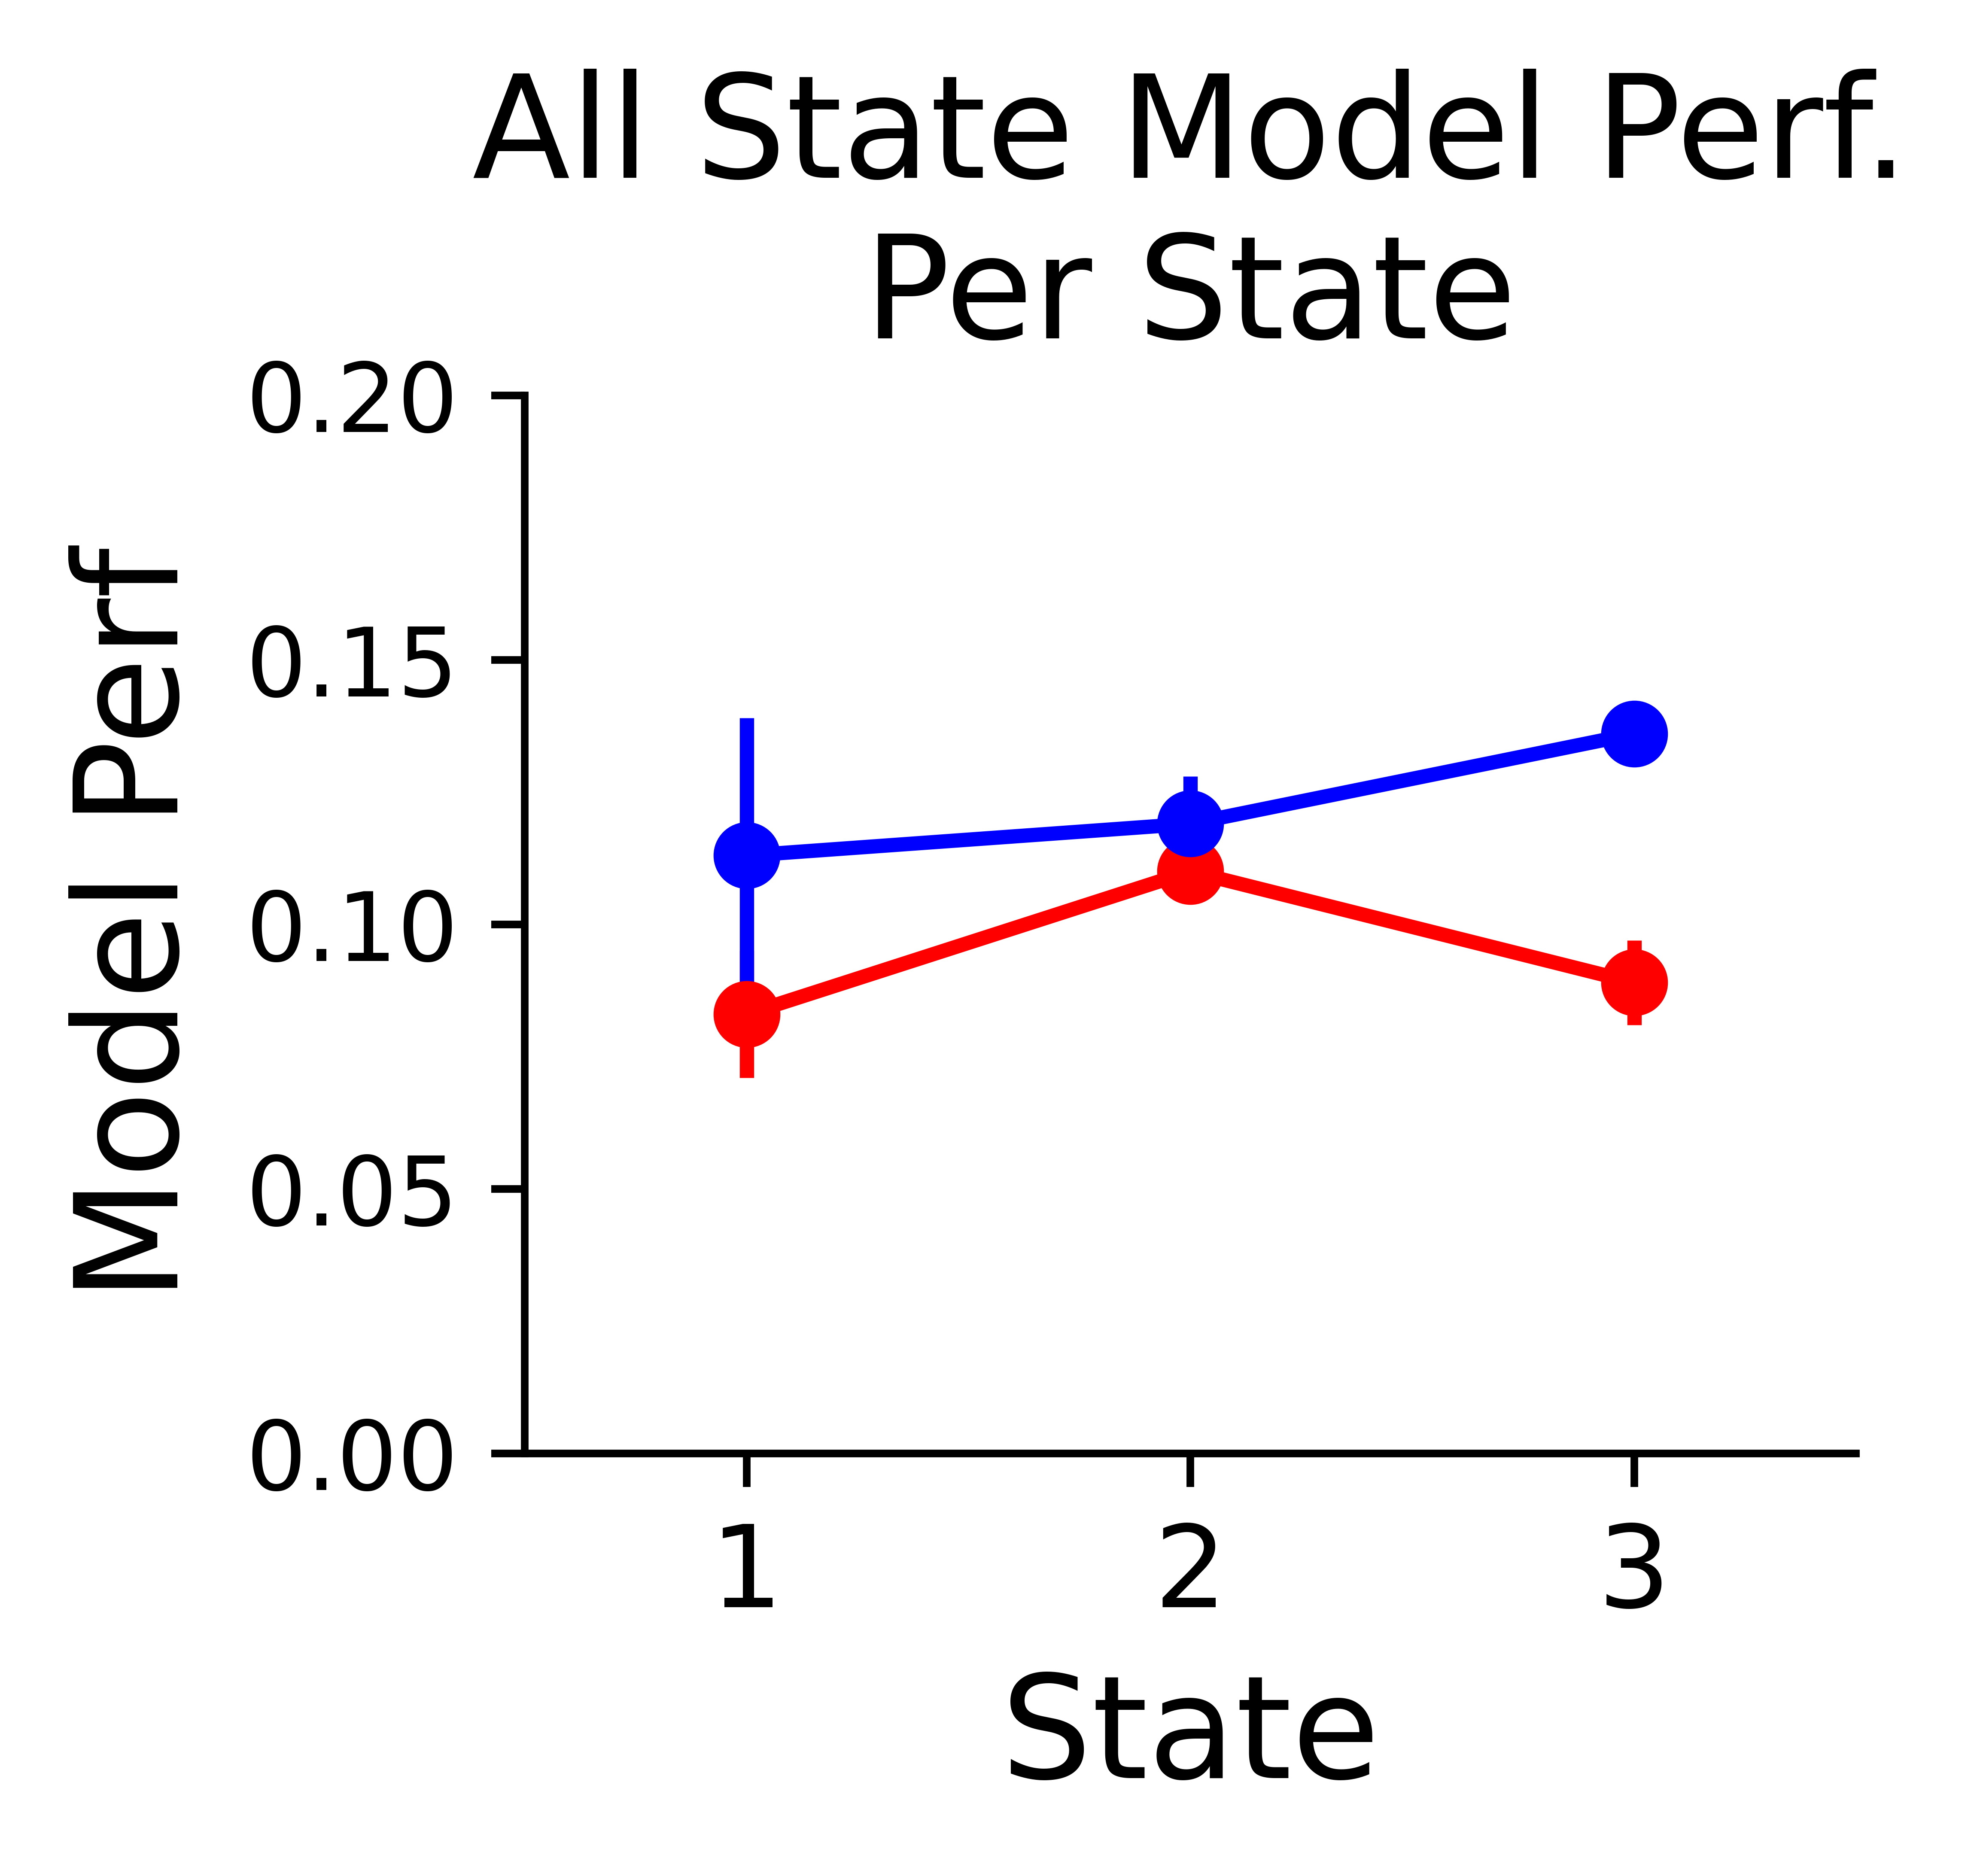

In [249]:
fig, axs = plt.subplots(1, figsize = (2.5,2), dpi=1600, sharey=False)

axs.errorbar(x=[1,2,3], y=[0.083, 0.110, 0.089], yerr=[0.012, 0.004, 0.008], fmt='o', color='red')
axs.plot([1,2,3], [0.083, 0.110, 0.089], color='red')

axs.errorbar(x=[1,2,3], y=[0.113, 0.119, 0.136], yerr=[0.026, 0.009, 0.006], fmt='o', color='blue')
axs.plot([1,2,3], [0.113, 0.119, 0.136], color='blue')

axs.set_ylim([0,.2])
axs.set_title("All State Model Perf.\nPer State", fontsize=15)
axs.set_xticks(list(range(1,4)))
axs.set_ylabel('Model perf.', fontsize=15)
axs.set_xticklabels(['1', '2', '3'], fontsize=12)
axs.set_xlim([0.5,3.5])
axs.set_xlabel('State', fontsize=15)


#axs.plot([1, 1, 2, 2], [3.8,3.8,3.8,4.4], lw=1, c='black')
#axs.text((1 + 2) / 2, 1.5, "NS", ha='center', va='bottom', color='black')

#axs.plot([1, 1, 2, 2], [23.8,25,25,13], lw=1, c='black')
#axs.text((1 + 2) / 2, 25, "***", ha='center', va='bottom', color='black')

plt.savefig(save_path + 'all_state_model_perf_states.svg', format='svg', bbox_inches="tight")